In [1]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output

## Loading the dataset

In [3]:
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Check the shapes of the data
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [4]:
def plot_image(image, label_true=None, class_names=None, label_pred=None):
    if image.ndim == 4 and image.shape[0] == 1:
        image = image[0]

    plt.grid()
    plt.imshow(image.astype(np.uint8))

    # Show true and predicted classes
    if label_true is not None and class_names is not None:
        labels_true_name = class_names[label_true]
        if label_pred is None:
            xlabel = "True: " + labels_true_name
        else:
            # Name of the predicted class
            labels_pred_name = class_names[label_pred]

            xlabel = "True: " + labels_true_name + "\nPredicted: " + labels_pred_name

        # Show the class on the x-axis
        plt.xlabel(xlabel)

    plt.xticks([])  # Remove ticks from the plot
    plt.yticks([])
    plt.show()  # Show the plot

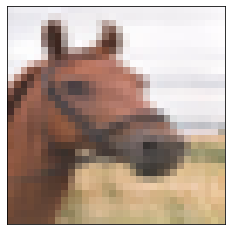

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
image_id = 99 # Image index in the test set
plot_image(x_test[image_id])

## Perturbating the Image

In [6]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs

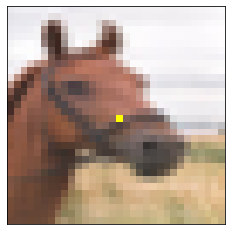

In [7]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

plot_image(image_perturbed)

## LeNet

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Dropout, Activation
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import json

#from networks.train_plot import PlotLearning  # Assuming you have this module

# Code taken from https://github.com/BIGBALLON/cifar-10-cnn
class LeNet5:
    def __init__(self, epochs=200, batch_size=128, load_weights=True, net_type = 'LeNet'):
        self.name               = net_type
        self.model_filename     = 'networks/models/'+ net_type +'.keras'
        self.num_classes        = 10
        self.input_shape        = (32, 32, 3)
        self.batch_size         = batch_size
        self.epochs             = epochs
        self.iterations         = 391
        self.weight_decay       = 0.0001
        self.log_filepath       = r'networks/models/' + net_type

        if load_weights:
            try:
                self._model = load_model(self.model_filename)
                print('Successfully loaded', self.name)
            except (ImportError, ValueError, OSError):
                print('Failed to load', self.name)

    def count_params(self):
        return self._model.count_params()

    def color_preprocessing(self, x_train, x_test):
        
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        mean = [125.307, 122.95, 113.865]
        std  = [62.9932, 62.0887, 66.7048]
        for i in range(3):
            x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
            x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
        return x_train, x_test

    def build_model(self):

        if self.name == 'LeNet':
            model = Sequential()
            model.add(Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=(32,32,3), padding='same'))
            model.add(AveragePooling2D(pool_size=2, strides = 2))
            model.add(Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'))
            model.add(AveragePooling2D(pool_size=2, strides = 2))
            model.add(Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'))
            model.add(Flatten())
            model.add(Dense(84, activation='relu'))
            model.add(Dense(10, activation='softmax'))

        elif self.name == 'All Convolution':
            model = Sequential()
            model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)))                
            model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
            model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
            model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
            model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))

            model.add(Dropout(0.3))

            model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))                   
            model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
            model.add(Conv2D(192, (1, 1), activation='relu', padding='valid'))
            model.add(Conv2D(10, (1, 1), activation='relu', padding='valid'))

            model.add(GlobalAveragePooling2D())
            model.add(Activation('softmax'))


        model.compile(optimizer=Adam(learning_rate=self.weight_decay),loss='categorical_crossentropy', metrics=['accuracy'])
        return model


    def train(self, data_aug=False, early_stopping=True, patience=10):

        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        y_train = tf.keras.utils.to_categorical(y_train, self.num_classes)
        y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        # Color preprocessing
        x_train, x_test = self.color_preprocessing(x_train, x_test)

        # Build network
        model = self.build_model()
        model.summary()

        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

        # EarlyStopping callback
        callbacks = []
        if early_stopping:
            early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            callbacks.append(early_stop)

        # using real-time data augmentation
        if data_aug:
            print('Using real-time data augmentation.')
            datagen = ImageDataGenerator(horizontal_flip=True,
                                        width_shift_range=0.125,
                                        height_shift_range=0.125,
                                        fill_mode='constant',
                                        cval=0.)

            datagen.fit(x_train)

            # start training with early stopping
            hist = model.fit(datagen.flow(x_train, y_train, batch_size=self.batch_size),
                            epochs=self.epochs,
                            validation_data=(x_test, y_test),
                            callbacks=callbacks)
        else:
            print('No data augmentation.')

            # start training with early stopping
            hist = model.fit(x_train, y_train, batch_size=self.batch_size,
                            epochs=self.epochs,
                            validation_data=(x_test, y_test),
                            callbacks=callbacks)
            
        # Save the history as a JSON file
        with open(self.log_filepath + 'training_history.json', 'w') as f:
            json.dump(hist.history, f)

        # save model
        model.save(self.model_filename)
        self._model = model

    def plot_history(self):

        # Load the history
        with open(self.log_filepath + 'training_history.json', 'r') as f:
            history = json.load(f)

        # Get the number of epochs
        epochs = range(1, len(history['loss']) + 1)

        # Plot training & validation loss values
        plt.figure(figsize=(12, 5))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['loss'], 'bo-', label='Training Loss')
        plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['accuracy'], 'bo-', label='Training Accuracy')
        plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.suptitle(self.name)
        plt.show()
        


    def color_process(self, imgs):
        if imgs.ndim < 4:
            imgs = np.array([imgs])
        imgs = imgs.astype('float32')
        mean = [125.307, 122.95, 113.865]
        std  = [62.9932, 62.0887, 66.7048]
        for img in imgs:
            for i in range(3):
                img[:, :, i] = (img[:, :, i] - mean[i]) / std[i]
        return imgs

    def predict(self, img):
        processed = self.color_process(img)
        return self._model.predict(processed, batch_size=self.batch_size)

    def predict_one(self, img):
        return self.predict(img)[0]

    def accuracy(self):
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        y_train = tf.keras.utils.to_categorical(y_train, self.num_classes)
        y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        # color preprocessing
        x_train, x_test = self.color_preprocessing(x_train, x_test)

        return self._model.evaluate(x_test, y_test, verbose=0)[1]


In [9]:
lenet5_1 = LeNet5(epochs=10, batch_size=128, load_weights=False)
lenet5_1.train(data_aug=True)

c:\Users\Ola\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │        40,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,246 (360.34 KB)

 Trainable params: 92,246 (360.34 KB)

 Non-trainable params: 0 (0.00 B)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Using real-time data augmentation.


c:\Users\Ola\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - accuracy: 0.2191 - loss: 2.1410 - val_accuracy: 0.3843 - val_loss: 1.7554
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.3591 - loss: 1.7843 - val_accuracy: 0.4268 - val_loss: 1.6071
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.3972 - loss: 1.6793 - val_accuracy: 0.4485 - val_loss: 1.5404
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - accuracy: 0.4177 - loss: 1.6167 - val_accuracy: 0.4592 - val_loss: 1.5082
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.4277 - loss: 1.5878 - val_accuracy: 0.4718 - val_loss: 1.4828
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.4421 - loss: 1.5590 - val_accuracy: 0.4805 - val_loss: 1.4587
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.4453 - loss: 1.5344 - val_accuracy: 0.4910 - val_loss: 1.4246
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.4562 - loss: 1.516

## Attack function

In [13]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

In [15]:
from DifferentialEvolution import differential_evolution

def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)

    # If the prediction is what we want (misclassification or
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    
def attack(img_id, model, target=None, pixel_count=1,
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]

    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count

    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))

    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class,
                               model, target is None)

    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class,
                              model, targeted_attack, verbose)

    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Confidence: 0.70945877
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Confidence: 0.70945877
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Confidence: 0.705836
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Confidence: 0.70360464
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Confidence: 0.70360464
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Confidence: 0.70360464
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Confidence: 0.70360464
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Confidence: 0.7025602
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Confidence: 0.7025602
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

c:\Users\Ola\Desktop\one_pixel_27.10\DifferentialEvolution.py:585: RuntimeWarning: divide by zero encountered in scalar divide
  convergence=self.tol / convergence) is True):


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Confidence: 0.69854665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Confidence: 0.69854665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Confidence: 0.69854665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Confidence: 0.69854665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Confidence: 0.69854665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Confidence: 0.69854665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Confidence: 0.69854665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Confidence: 0.69854665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Confidence: 0.69854665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


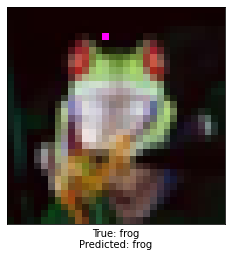

In [16]:
image_id = 102
pixels = 1 # Number of pixels to attack
model = lenet5_1

_ = attack(image_id, model, pixel_count=pixels, verbose=True)

## Brudnopis

c:\Users\Ola\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 192)      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 10)       │         1,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,369,738 (5.23 MB)

 Trainable params: 1,369,738 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
No data augmentation.
Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 971s 2s/step - accuracy: 0.2007 - loss: 2.1785 - val_accuracy: 0.3630 - val_loss: 1.7967
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 769s 2s/step - accuracy: 0.3644 - loss: 1.7814 - val_accuracy: 0.4412 - val_loss: 1.4819
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.4646 - loss: 1.4623 - val_accuracy: 0.5140 - val_loss: 1.3294
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 856s 2s/step - accuracy: 0.5125 - loss: 1.3419 - val_accuracy: 0.5327 - val_loss: 1.2933
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 781s 2s/step - accuracy: 0.5480 - loss: 1.2482 - val_accuracy: 0.5577 - val_loss: 1.2257
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 791s 2s/step - accuracy: 0.5711 - loss: 1.1856 - val_accuracy: 0.5856 - val_loss: 1.1839
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 772s 2s/step - accuracy: 0.5916 - loss: 1.1313 - val_accuracy: 0.6183 - val_loss: 1.0894
Epoch 

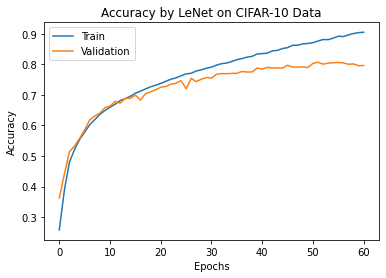

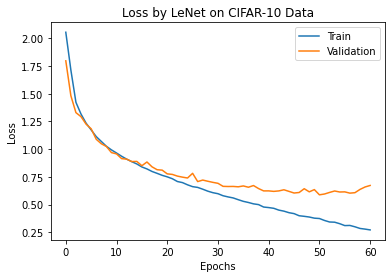

In [22]:
AllConv = LeNet5(epochs=100, batch_size=128, load_weights=False, net_type='allconv')
AllConv.train()

In [24]:
AllConv2 = LeNet5(epochs=100, batch_size=128, load_weights=True, net_type='allconv')

Successfully loaded allconv


c:\Users\Ola\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 192)      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 10)       │         1,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,369,738 (5.23 MB)

 Trainable params: 1,369,738 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Using real-time data augmentation.


c:\Users\Ola\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 834s 2s/step - accuracy: 0.2096 - loss: 2.1382 - val_accuracy: 0.3767 - val_loss: 1.6868
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 842s 2s/step - accuracy: 0.3773 - loss: 1.6708 - val_accuracy: 0.4497 - val_loss: 1.5138
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - accuracy: 0.4350 - loss: 1.5464 - val_accuracy: 0.4734 - val_loss: 1.4448
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 819s 2s/step - accuracy: 0.4643 - loss: 1.4692 - val_accuracy: 0.5072 - val_loss: 1.3661
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 8253s 21s/step - accuracy: 0.4901 - loss: 1.4042 - val_accuracy: 0.5263 - val_loss: 1.3266
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.5124 - loss: 1.3539 - val_accuracy: 0.5390 - val_loss: 1.2761
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 822s 2s/step - accuracy: 0.5326 - loss: 1.3071 - val_accuracy: 0.5714 - val_loss: 1.2071
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.5531 - loss: 1.2484 

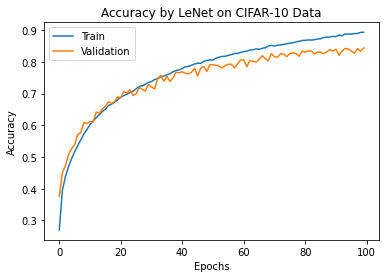

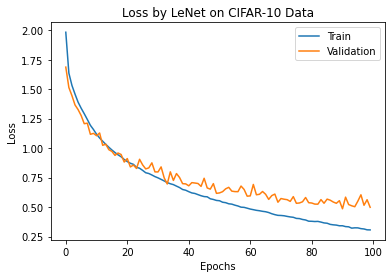

In [23]:
AllConv_with_data_aug = LeNet5(epochs=100, batch_size=128, load_weights=False, net_type='allconv')
AllConv_with_data_aug.train(data_aug=True)

c:\Users\Ola\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 16, 16, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 6, 6, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 84)             │        40,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,246 (360.34 KB)

 Trainable params: 92,246 (360.34 KB)

 Non-trainable params: 0 (0.00 B)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
Using real-time data augmentation.


c:\Users\Ola\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - accuracy: 0.3075 - loss: 1.9038 - val_accuracy: 0.4630 - val_loss: 1.4756
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.4429 - loss: 1.5348 - val_accuracy: 0.5109 - val_loss: 1.3564
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.4824 - loss: 1.4275 - val_accuracy: 0.5396 - val_loss: 1.2748
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.5196 - loss: 1.3404 - val_accuracy: 0.5678 - val_loss: 1.2054
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.5406 - loss: 1.2847 - val_accuracy: 0.5779 - val_loss: 1.1740
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.5631 - loss: 1.2310 - val_accuracy: 0.5779 - val_loss: 1.2035
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.5723 - loss: 1.2015 - val_accuracy: 0.6174 - val_loss: 1.0747
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.5822 -

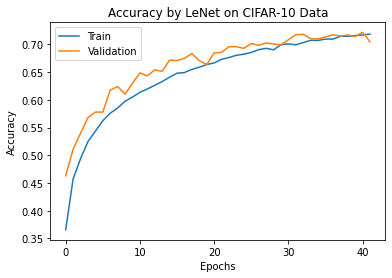

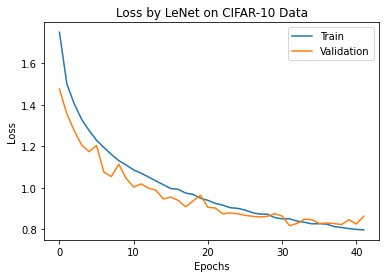

In [16]:
lenet5_2 = LeNet5(epochs=100, batch_size=128, load_weights=False)
lenet5_2.train(data_aug=True)